In [6]:
from neuro_py.io import loading
from neuro_py.tuning import maps


import neuro_py as npy
import numpy as np
import matplotlib.pyplot as plt
import nelpy as nel


In [7]:
# basepath = r'Y:\laura_berkowitz\app_ps1_ephys\external_data\AZ10\AZ10_210414_sess10'
# basepath = r'Y:\laura_berkowitz\app_ps1_ephys\data\hpc13\hpc13_day33_240813_114349'
basepath = r'Y:\laura_berkowitz\app_ps1_ephys\data\hpc07\hpc07_day29_220528_1105'
# basepath = r'Y:\laura_berkowitz\app_ps1_ephys\data\hpc15\hpc15_day25_241017_093405'

In [8]:
# load position
position_df = loading.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df[["x", "y"]].values.T,
    timestamps=position_df.timestamps.values,
)
# calculate speed
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)

# load in spike data from hpc pyramidal cells
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1|CA2|CA3"
)

In [9]:
epoch_df = loading.load_epoch(basepath)
trial_df = loading.load_trials(basepath)
epoch_df = npy.session.compress_repeated_epochs(epoch_df)
epochs = nel.EpochArray(
    np.array([epoch_df.startTime, epoch_df.stopTime]).T
)
beh_epochs = nel.EpochArray(np.array([trial_df.startTime, trial_df.stopTime]).T)

# you can change this based on which session you want to look at
behavior_idx = 1

# print out data frame
trial_df

,startTime,stopTime,trialsID
0,7086.094300,7692.836900,object_learning_1
1,7944.200533,8557.343200,object_learning_2
2,8804.573567,9430.516067,object_learning_3
3,20609.291467,21815.743433,object_test_1


In [10]:
epochs[1] & beh_epochs[:3], beh_epochs[:3]

(<EpochArray at 0x21040621f50: 3 epochs> of length 30:45:827 minutes,
 <EpochArray at 0x2104045fe50: 3 epochs> of length 30:45:827 minutes)

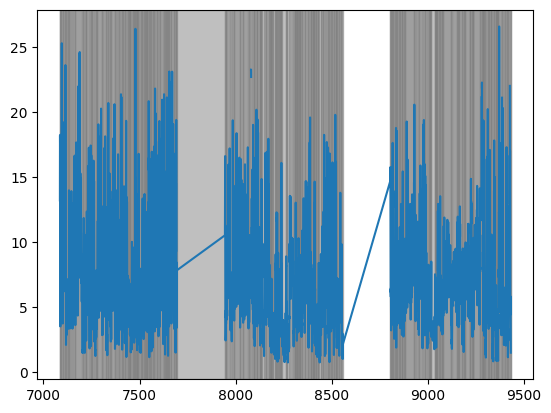

In [16]:
plt.plot(speed[beh_epochs[:3]].abscissa_vals,speed[beh_epochs[:3]].data[0,:])
nel.plotting.epochplot(pos[beh_epochs[:3]].support)
run_epochs = nel.utils.get_run_epochs(
    speed[beh_epochs[:3]], v1=4, v2=4
).merge()
for epoch_ in run_epochs:
    plt.axvspan(epoch_.start, epoch_.stop, color='gray', alpha=0.5)

In [17]:
pos[epochs[1]].support, epochs[1]

(<EpochArray at 0x21034cb8e90: 1 epoch> of length 43:22:051 minutes,
 <EpochArray at 0x21042d47090: 1 epoch> of length 47:20:575 minutes)

In [13]:
ts = np.arange(-40,40,1/20)

spatial_info = []
for offset in ts:
    st_current = st.copy()
    st_current._data = st_current._data + offset
    spatial_maps = maps.SpatialMap(
        pos[epochs[1]],
        st_current[epochs[1]],
        s_binsize=2,
        speed=speed[epochs[1]],
        speed_thres=4
    )

    spatial_info.append(spatial_maps.spatial_information())

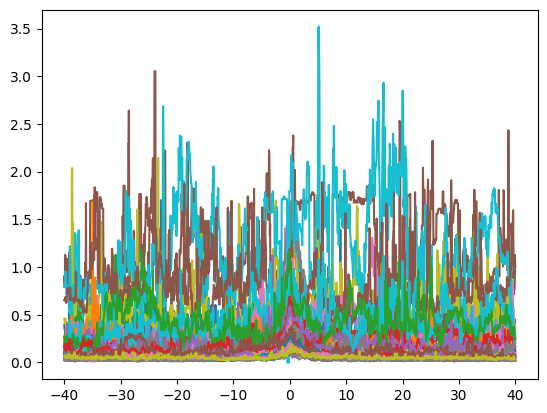

In [14]:
plt.plot(ts,np.array(spatial_info))

plt.show()

Max spatial information at offset: 0.14999999999771774 s


Text(0.5, 0, 'Offset (s)')

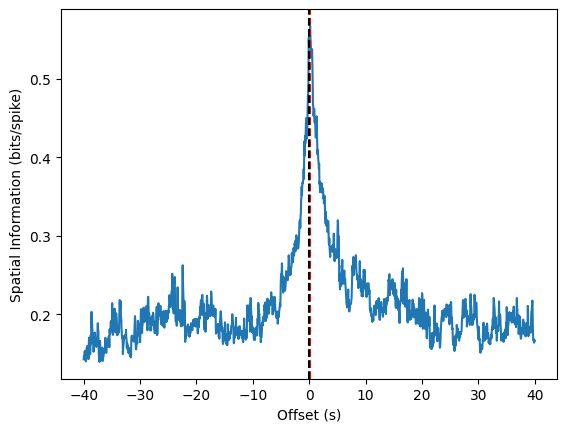

In [15]:

plt.plot(ts,np.nanmean(np.array(spatial_info),axis=1))

idx = np.argmax(np.nanmean(np.array(spatial_info),axis=1))
plt.axvline(ts[idx], color='r', linestyle='--')
print(f"Max spatial information at offset: {ts[idx]} s")
plt.axvline(0, color='k', linestyle='--')
plt.ylabel("Spatial Information (bits/spike)")
plt.xlabel("Offset (s)")
# plt.xlim(-40, 40)
# plt.ylim(0.8, 1.5)